# Programming Assignment-2
The goal of this assingment is to allow you to practice several the following things in Python:
1. Perfoming typical data processing (or preprocessing if you prefer). This includes all the typical data wraning such as creating news variables, combining several datasets and more 
2. Running explolatory data analysis including basic plotting of variables 
3. Perfoming basic inferential statisticals using statsmodels and scipy to run hypythesis testing and build simple statistial or econometric models.

## Datasets 
For this assignment, you will use the following datasets:
### Rwanda Health Indicators
The Excel file was generated by combining multiple CSV files, each containing data on different health indicators for Rwanda, So that each sheet in the file represent one such indicator. See below some of the input files which were used:
- `access-to-health-care_subnational_rwa`
- `child-mortality-rates_subnational_rwa`
- `dhs-mobile_subnational_rwa`

You can download the dataset from [here](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true).
### Nights lights Data
- Please download it [here](https://drive.google.com/file/d/1f_4fiqxIejly0YmC088s9bxOfrABv9Sz/view?usp=sharing) and check the documentation in the cells below. 

### Popupation Dataset
- Please download it [here](https://drive.google.com/file/d/1FWEFGdN-xDuFH1jmt0hr4F8Xc3Y5XzvB/view?usp=share_link) and check the documentation and metadata in the class notebooks.


## Submission Guidelines 
- Please guidelines and complete all steps in the [GitHub Workflow](https://dmatekenya.github.io/AIMS-DSCBI/course-requirements/github-workflow.html)
- Once you have completed your assignment, push chanegs to your repository.
- Send a link (copy from within GitHub) to your notebook to the tutors/teaching assistants


# Import Required Packages

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Setup Input Folders

As usual, it is good practice to set up input folders using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) package. In this section, make sure to define the folders where your data is stored on your machine.

I find it helpful to set up the working directory and input data folders right at the start of the notebook. To keep things organized, I use the naming convention: `FILE_{NAME}` for files and `DIR_{NAME}` for folders. We use capital letters because these are global variables that will be referenced throughout the notebook.

We'll be using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) library, which offers several advantages over traditional string-based path handling:

- **Cross-platform compatibility** - automatically handles path separators (`/` vs `\`) across different operating systems
- **Object-oriented approach** - paths are objects with useful methods rather than strings
- **Intuitive syntax** - use `/` operator to join paths naturally: `parent_dir / "subfolder" / "file.txt"`
- **Built-in path operations** - methods like `.exists()`, `.is_file()`, `.parent`, `.stem`, and `.suffix`
- **Safer path manipulation** - reduces errors from manual string concatenation and splitting

This is the recommended approach for managing file paths in modern Python development.


In [2]:
# Uncomment the following lines and add your code to define the directories and files
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_EXCEL = DIR_DATA/"rwanda/RW-Health-Data.xlsx"

# Population by enumeration area (EA) for Rwanda
FILE_CELL_POP_RW = DIR_DATA/"population-demography/rwa-cell-pop.csv"

# Nightlight data for Rwanda
FILE_CELL_NTL_RW = DIR_DATA/"ntl/cell-ntl-2015-2020-2024.csv"


# Part 1: Processing Excel Files
The primary goal is to preprocess an [Excel file](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true) with multiple sheets into a unified CSV dataset that consolidates multiple indicators. Having all indicators in a single file at the same analytical unit (national, subnational) is more efficient than managing separate files and enables easier cross-indicator analysis.

## Task 1: Generate National-Level Summaries

For each indicator, compute a single national-level value using appropriate aggregation functions such as **mean**, **sum** or **count**. For this one, all available indicators can be summarized at national level, so we will have a CSV file with one row and 

### Expected Output Structure
1. **DataFrame display** in Jupyter Notebook
2. **CSV file** with columns:
- `indicator_name`: Name of the indicator
- `aggregated_value`: Computed national value
- `indicator_year`: Survey year or something similar
- `survey_name`: Name of the survey where information is coming from
- `aggregation_method`: Statistical method used (optional)

## Task 2: Subnational-Level Indicator Dataset

Create a merged dataset for indicators with subnational data (ADM2/ADM3 levels), ensuring spatial alignment and consistent administrative boundaries.

### Expected Output Structure
   - `indicator_name`: Name of the indicator
   - `aggregated_value`: Computed national value
   - `indicator_year`: Survey year or something similar
   - `survey_name`: Name of the survey where information is coming from
   - `aggregation_method`: Statistical method used (optional)

This structure enables both single-indicator and multi-indicator analysis at the subnational level.

## Task-1: National Level Indicators 
The process to generate national summaries is fairly straigtfoward because all we need is to generate naitonal averages for each indicator. However, for the processing, we need to make sure that for each indicator, we aggregate values from the same year. This is the process I follow:

This process extracts national-level health indicators from an Excel file containing multiple sheets, each representing a different indicator. For each sheet, it removes the first row (which does not contain data), keeps only the relevant columns, and calculates the national average for each indicator and survey year. The results from all sheets are combined into a single summary table, which is then saved as a CSV file for further analysis. This approach ensures that all national-level indicator values are consistently aggregated and organized in one place.

To make our code neat,we define a function which does the processing above and saves a CSV file.

In [3]:
# =====================================================
# LOAD EXCEL FILE AND CHECK SHEET NAMES
# ======================================================
# Get all sheet names
sheet_names = pd.ExcelFile(FILE_EXCEL).sheet_names

# After manually reviewing columns, we only keep these 
# columns
COLS_TO_KEEP = ['CountryName', 'ISO3', 'Location', 'Indicator', 'Value',
                'SurveyYear', 'SurveyId','SurveyYearLabel']


In [4]:
def extract_national_indicators(excel_path):
    """
    Extract national level indicators from an Excel file with multiple sheets.
    
    Parameters:
    -----------
    excel_path : Path or str
        Path to the Excel file containing health indicator data
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing national level indicators
    """
    # Get all sheet names
    sheet_names = pd.ExcelFile(excel_path).sheet_names
    
    # Initialize a list to store national level indicators
    national_indicators = []

    # Loop through each sheet
    for sheet in sheet_names:
        # Read the sheet
        df = pd.read_excel(excel_path, sheet_name=sheet)

        # Drop the first row (which typically contains metadata) and reset index
        df = df.iloc[1:].reset_index(drop=True)
        
        # Keep only the specified columns if they exist
        if all(col in df.columns for col in COLS_TO_KEEP):
            df = df[COLS_TO_KEEP]
        else:
            # Skip sheets that don't have the expected columns
            print(f"Skipping sheet {sheet} due to missing expected columns")
            continue
        
        # Convert Value column to numeric (will convert errors to NaN)
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        
        # Group by Indicator and SurveyYear to calculate national averages
        grouped = df.groupby(['Indicator', 'SurveyYear']).agg({
            'Value': 'mean',
            'SurveyId': 'first',
            'SurveyYearLabel': 'first'
        }).reset_index()
        
        # Add the national indicators to our list
        for _, row in grouped.iterrows():
            national_indicators.append({
                'indicator_name': row['Indicator'],
                'aggregated_value': row['Value'],
                'indicator_year': row['SurveyYear'],
                'survey_name': row['SurveyId'],
                'survey_year_label': row['SurveyYearLabel'],
                'aggregation_method': 'mean',
                'source_sheet': sheet
            })

    # Create a DataFrame from the list
    national_df = pd.DataFrame(national_indicators)
    
    return national_df

In [5]:
# ==========================================================
# CALL THE FUNCTION
# ==========================================================
# Extract the national indicators
df_rw = extract_national_indicators(FILE_EXCEL)

# Display the first few rows
print(f"Total national indicators created: {len(df_rw)}")
display(df_rw.head(10))

# Save to CSV
output_path = DIR_DATA / "rwanda/national_indicators.csv"
df_rw.to_csv(output_path, index=False)
print(f"Saved national indicators to {output_path}")

Total national indicators created: 1850


,indicator_name,aggregated_value,indicator_year,survey_name,survey_year_label,aggregation_method,source_sheet
0,Accepting attitudes towards those living with ...,48.660000,2005,RW2005DHS,2005,mean,dhs-mobile_subnational_rwa
1,Accepting attitudes towards those living with ...,64.260000,2010,RW2010DHS,2010,mean,dhs-mobile_subnational_rwa
2,Accepting attitudes towards those living with ...,62.820000,2015,RW2015DHS,2014-15,mean,dhs-mobile_subnational_rwa
3,Accepting attitudes towards those living with ...,47.520000,2005,RW2005DHS,2005,mean,dhs-mobile_subnational_rwa
4,Accepting attitudes towards those living with ...,52.840000,2010,RW2010DHS,2010,mean,dhs-mobile_subnational_rwa
5,Accepting attitudes towards those living with ...,49.260000,2015,RW2015DHS,2014-15,mean,dhs-mobile_subnational_rwa
6,Antenatal care from a skilled provider,93.688095,1992,RW1992DHS,1992,mean,dhs-mobile_subnational_rwa
7,Antenatal care from a skilled provider,92.398039,2000,RW2000DHS,2000,mean,dhs-mobile_subnational_rwa
8,Antenatal care from a skilled provider,94.313333,2005,RW2005DHS,2005,mean,dhs-mobile_subnational_rwa
9,Antenatal care from a skilled provider,95.913333,2008,RW2008DHS,2007-08,mean,dhs-mobile_subnational_rwa


Saved national indicators to /Users/dmatekenya/Library/CloudStorage/GoogleDrive-dmatekenya@gmail.com/My Drive/TEACHING/AIMS-DSCBI/data/rwanda/national_indicators.csv


## Task-2: Subnational Indicators

To create a comprehensive subnational indicator dataset, we first need to understand which indicators are available at the district (ADM2) level. Rwanda has 30 districts, so we'll focus on sheets that contain data with approximately this number of unique locations.

Our approach involves:

1. Examining the data structure to identify which indicators are available at district level
2. Extracting these indicators while preserving their spatial and temporal context
3. Standardizing the district names to ensure consistent spatial referencing
4. Creating a unified dataset that allows for both single-indicator and cross-indicator analysis

This process is more complex than the national-level aggregation because we need to maintain the spatial dimension and ensure proper alignment across indicators collected in different years or from different surveys. The function below implements this extraction logic, filtering for sheets that contain district-level data.

For manual inspection of variables, I used something like this:
```sheet_names = pd.ExcelFile(FILE_EXCEL).sheet_names
df = pd.read_excel(FILE_EXCEL, sheet_name=sheet_names[0])

# Pick indicator to work with 
df_indicator = df.query('Indicator == "Women who want no more children"')
yrs = df_indicator.SurveyYear.unique()

# Unique Locations for each survey year
locations = {yr: len(df_indicator.query('SurveyYear == @yr').Location.unique()) for yr in yrs} 
```

In [6]:
def extract_adm2_indicators(excel_path):
    """
    Extract indicators available at ADM2 (district) level from an Excel file with multiple sheets.
    This function checks for district-level granularity at the indicator and year level,
    rather than just at the sheet level.

    Parameters:
    -----------
    excel_path : Path or str
        Path to the Excel file containing health indicator data

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing ADM2-level indicators
    """
    # Get all sheet names
    sheet_names = pd.ExcelFile(excel_path).sheet_names

    # Initialize a list to store ADM2 indicators
    adm2_indicators = []

    # Loop through each sheet
    for sheet in sheet_names:
        try:
            # Read the sheet
            df = pd.read_excel(excel_path, sheet_name=sheet)

            # Drop the first row (which typically contains metadata) and reset index
            df = df.iloc[1:].reset_index(drop=True)

            # Keep only the specified columns if they exist
            if all(col in df.columns for col in COLS_TO_KEEP):
                df = df[COLS_TO_KEEP]
            else:
                print(f"Skipping sheet {sheet} due to missing expected columns")
                continue

            # Convert Value column to numeric
            df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

            # Process by indicator and year combination to check for district-level data
            for (indicator, year), group in df.groupby(['Indicator', 'SurveyYear']):
                unique_locs = group['Location'].dropna().unique()
                
                # Check if this indicator-year combination has district-level data
                # Rwanda has 30 districts, but we'll accept 6-35 to account for potential changes
                # or different naming conventions
                if 6 <= len(unique_locs) <= 35:
                    # Group by Location to get district-level means
                    for _, row in group.groupby('Location').agg({
                        'Value': 'mean',
                        'SurveyId': 'first',
                        'SurveyYearLabel': 'first'
                    }).reset_index().iterrows():
                        adm2_indicators.append({
                            'indicator_name': indicator,
                            'district': row['Location'],
                            'aggregated_value': row['Value'],
                            'indicator_year': year,
                            'survey_name': row['SurveyId'],
                            'survey_year_label': row['SurveyYearLabel'],
                            'aggregation_method': 'mean',
                            'source_sheet': sheet
                        })
                else:
                    print(f"Skipping indicator '{indicator}' for year {year} - not at district level (found {len(unique_locs)} unique locations)")
                    
        except Exception as e:
            print(f"Error processing sheet {sheet}: {e}")

    # Create a DataFrame from the list
    adm2_df = pd.DataFrame(adm2_indicators)
    
    # Add district count per indicator-year combination for validation
    if not adm2_df.empty:
        district_counts = adm2_df.groupby(['indicator_name', 'indicator_year']).size().reset_index(name='district_count')
        print(f"Created dataset with {len(adm2_df)} rows across {len(district_counts)} indicator-year combinations")
    else:
        print("No district-level indicators found")

    return adm2_df

In [7]:
df_adm2 = extract_adm2_indicators(excel_path=FILE_EXCEL)

Skipping indicator 'Accepting attitudes towards those living with HIV - Composite of 4 components [Men]' for year 2005 - not at district level (found 5 unique locations)
Skipping indicator 'Accepting attitudes towards those living with HIV - Composite of 4 components [Men]' for year 2010 - not at district level (found 5 unique locations)
Skipping indicator 'Accepting attitudes towards those living with HIV - Composite of 4 components [Men]' for year 2015 - not at district level (found 5 unique locations)
Skipping indicator 'Accepting attitudes towards those living with HIV - Composite of 4 components [Women]' for year 2005 - not at district level (found 5 unique locations)
Skipping indicator 'Accepting attitudes towards those living with HIV - Composite of 4 components [Women]' for year 2010 - not at district level (found 5 unique locations)
Skipping indicator 'Accepting attitudes towards those living with HIV - Composite of 4 components [Women]' for year 2015 - not at district level (

## Introduction to Nightlights Dataset

## What is Nightlight Data?

Nightlight data is satellite imagery capturing artificial light emissions from Earth's surface during nighttime. Satellites like VIIRS collect this data regularly, providing an **objective, real-time measure of human economic activity and development**.

### Raw Data: Radiance Measurements
The fundamental measurement in nightlight data is **radiance** - the amount of light energy detected by satellite sensors, measured in **nanowatts per square centimeter per steradian (nW/cm²/sr)**. Each pixel in satellite imagery contains a radiance value representing the light intensity from that specific location on Earth's surface.

### Annual Composite Generation
This dataset was created from **annual composite images** using VIIRS nightlight files for Rwanda. Annual composites are generated by:

- **Aggregating daily/monthly observations** throughout each year (2015, 2020, 2024)
- **Filtering out temporary light sources** (fires, lightning, aurora)
- **Removing cloud-affected observations** to ensure clear measurements
- **Averaging or taking median values** to create stable, representative annual measurements
- **Masking techniques** to exclude areas with unreliable data

The files used include both **average composites** (`average_masked`) and **median composites** (`median_masked`), with **cloud-free versions** (`vcmslcfg`) preferred over cloud-inclusive versions (`vcmcfg`) for more accurate measurements.

### Why Use Nightlight Data?

- **Consistent global coverage** - Available everywhere, regardless of local data quality
- **Real-time updates** - More current than traditional economic statistics
- **Objective measurement** - Not subject to reporting biases
- **High resolution** - Captures local development patterns
- **Proxy for development** - Light intensity correlates with economic activity, infrastructure, and quality of life

## Dataset Overview 

- **6,507 observations** across Rwanda's administrative cells
- **Three time periods**: 2015, 2020, 2024
- **Cell-level data** - Rwanda's smallest administrative units
- Allows temporal analysis of development trends

---

## Variable Definitions

### Administrative Identifiers
- **`cell_id`** - Unique identifier for linking with other datasets
- **`province_name`** - Province (5 total in Rwanda)
- **`district_name`** - District (30 total in Rwanda) 
- **`sector_name`** - Administrative level between district and cell
- **`cell_name`** - Specific cell name

### Core Nightlight Measurements

#### `total_nightlight`
- **Sum of all radiance values** within cell boundaries
- **Key indicator** of overall economic activity/development
- Higher values = more total development

#### `mean_nightlight` 
- **Average radiance** per pixel
- Indicates development intensity regardless of cell size
- Useful for comparing cells of different areas

#### `median_nightlight`
- **Middle radiance value** of all pixels (less sensitive to outliers)
- Better represents typical lighting in unevenly developed areas

#### `max_nightlight`
- **Highest radiance** within cell
- Indicates major infrastructure (hospitals, commercial centers)

#### `min_nightlight` & `std_nightlight`
- Minimum radiance and standard deviation
- High std = uneven development within cell

### Spatial Coverage Indicators

#### `pixel_count`
- **Total pixels** in cell (indicates geographic size)
- Used to normalize other measurements

#### `lit_pixel_count`
- **Number of pixels with detectable light** (radiance > 0)
- Shows spatial extent of development

#### `lit_pixel_percentage`
- **Percentage of cell area with lighting**
- Formula: `(lit_pixel_count ÷ pixel_count) × 100`
- **0% = completely dark, 100% = fully developed**

#### `year`
- Time period: 2015, 2020, or 2024

# Part-2: Demographic and Nightlights Data

## Part A: Varible Generation and Data Integration

### Population Dataset Variables (`rwa-cell-pop.csv`):
Create the following derived variables:
- **`dependency_ratio`** - `(children_under_five_2020 + elderly_60_plus_2020) / working_age_population * 100`
- **`people_per_building`** - `general_2020 / building_count`
- **`working_age_population`** - `general_2020 - children_under_five_2020 - elderly_60_plus_2020`
- **`infrastructure_index`** - Your own formula that incorporates `people_per_building` and other relevant variables to measure infrastructure adequacy. Document and justify your `infrastructure_index` methodology, explaining how `people_per_building` and other variables contribute to measuring infrastructure pressure.

### Nightlight Dataset Variables (`cell-ntl-2015-2020-2024.csv`):
Create the following temporal and development indicators:
- **`nightlight_change_2015_2024`** - Percentage change in total nightlight from 2015 to 2024
- **`mean_nightlight_change_2015_2024`** - Percentage change in mean nightlight from 2015 to 2024
- **`lit_pixel_percentage`** - Use existing or calculate: `(lit_pixel_count / pixel_count) * 100`

### Data Integration:
Merge the datasets using the appropriate column. 

## Part B: Exploratory Data Analysis

### Correlation Analysis:
1. **Correlation Heatmap**: Create a heatmap showing correlations between 10 key variables (mix of demographic, infrastructure, and nightlight variables). 
2. **Report the top 3 variable pairs** with the highest correlations and interpret their relationships.
3. **Identify unexpected correlations** and discuss potential explanations.

### Nightlight Trend Analysis:
1. **District Ranking**: Report the **top 5 districts** with the highest nightlight growth (2015-2024) and **bottom 5 districts** with the most decline or lowest growth.
2. **Lit Pixel Analysis**: Compare these districts using `lit_pixel_percentage` changes to understand whether growth represents intensification or spatial expansion.
3. **Create visualizations** showing nightlight trends for these extreme districts.

## Part C: Modeling


### Multivariate Linear Regression:
1. **Model Development**: Build a multivariate linear regression model predicting **population density** using both demographic and nightlight variables as predictors. Explore as many variables as possible at the beginning.
2. **Variable Selection**: Test different combinations of variables and report the **top 3 most predictive variables** of population density.
3. **Model Evaluation**: Report R-squared, coefficients, and statistical significance. Interpret what these results tell us about population-infrastructure relationships.



## Notes and Other Requirements
Please follow the genral guidelines below when preparing your analysis..

### Statistical Analysis:
- Properly handle missing data and outliers
- Use appropriate statistical tests and report p-values
- Calculate and interpret correlation coefficients
- Validate regression assumptions (normality, homoscedasticity)

### Data Management:
- Document all data cleaning and aggregation steps using markdown 
- Ensure consistent district naming across datasets

### Visualization Standards:
- Create clear, publication-quality heatmaps with appropriate color scales
- Design effective time series plots for nightlight trends
- Include proper axis labels, titles, and legends
- Use consistent formatting across all visualizations

### Reporting Requirements:
- Clearly state the top 3 most predictive variables with statistical justification
- Provide ranked lists for nightlight growth districts with supporting metrics
- Include model performance statistics and interpretation
- Document all methodological choices and assumptions

## Create Population Dataset Variables

In [10]:
df_pop = pd.read_csv(FILE_CELL_POP_RW)
df_ntl = pd.read_csv(FILE_CELL_NTL_RW)

In [11]:
# ==================================================================
# GENERATE ADDITIONAL VARIABLES IN POPULAITON DATAFRAME
# ==================================================================

# Create derived variables for population dataset
df_pop['working_age_population'] = (df_pop['general_2020'] - 
                                   df_pop['children_under_five_2020'] - 
                                   df_pop['elderly_60_plus_2020'])


# Calculate dependency ratio
df_pop['dependency_ratio'] = ((df_pop['children_under_five_2020'] + df_pop['elderly_60_plus_2020']) / 
                             df_pop['working_age_population'] * 100)

# Handle infinity values in dependency ratio
# We fill with median but these cn be left as NaN
df_pop['dependency_ratio'] = df_pop['dependency_ratio'].replace([np.inf, -np.inf], np.nan)
df_pop['dependency_ratio'].fillna(df_pop['dependency_ratio'].median(), inplace=True)

# Calculate people per building
# We fill NaN with median but these cn be left as NaN
df_pop['people_per_building'] = df_pop['general_2020'] / df_pop['building_count']
df_pop['people_per_building'] = df_pop['people_per_building'].replace([np.inf, -np.inf], np.nan)
df_pop['people_per_building'].fillna(df_pop['people_per_building'].median(), inplace=True)

# Create population density (people per unit area proxy)
df_pop['total_population'] = df_pop['general_2020']  # Using total population as proxy

# Create Infrastructure Index

/var/folders/04/tc5rvshj26363cf30dxyhz4c0000gp/T/ipykernel_31686/3386350694.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pop['dependency_ratio'].fillna(df_pop['dependency_ratio'].median(), inplace=True)
/var/folders/04/tc5rvshj26363cf30dxyhz4c0000gp/T/ipykernel_31686/3386350694.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

In [12]:
# Create Infrastructure Index based only on people_per_building

# Calculate z-scores for people_per_building (how many standard deviations from mean)
df_pop['people_per_building_zscore'] = (df_pop['people_per_building'] - df_pop['people_per_building'].mean()) / df_pop['people_per_building'].std()

# Infrastructure index - invert and scale to 0-100 range
# Lower people_per_building means better infrastructure (less crowding)
# We invert the z-score and scale to 0-100 range where higher = better infrastructure

# Find min and max z-scores for scaling
min_z = df_pop['people_per_building_zscore'].min()
max_z = df_pop['people_per_building_zscore'].max()

# Create the infrastructure index (scaled 0-100)
# Subtract from max_z to invert (lower people_per_building = higher infrastructure index)
df_pop['infrastructure_index'] = 100 * (max_z - df_pop['people_per_building_zscore']) / (max_z - min_z)

# Round to 2 decimal places
df_pop['infrastructure_index'] = df_pop['infrastructure_index'].round(2)


### Create Nightlight Dataset Variables


In [22]:
# ==================================================================
# GENERATE ADDITIONAL NTL VARIABLES
# ==================================================================

# Pivot nightlight data to get values by year
df_ntl_pivot = df_ntl.pivot_table(
    index=['cell_id', 'province_name', 'district_name', 'sector_name', 'cell_name'],
    columns='year',
    values=['total_nightlight', 'mean_nightlight', 'lit_pixel_count', 'pixel_count'],
    aggfunc='first'
).reset_index()

# Flatten column names
df_ntl_pivot.columns = ['_'.join([str(col[0]), str(col[1])]) if col[1] != '' 
                    else str(col[0]) for col in df_ntl_pivot.columns]

# Clean column names
df_ntl_pivot.columns = [col.replace('_', '') if col.endswith('_') else col for col in df_ntl_pivot.columns]

# Calculate nightlight changes (2015-2024)
# Replace division by zero with NaN instead of adding a small value
df_ntl_pivot['nightlight_change_2015_2024'] = np.where(
    df_ntl_pivot['total_nightlight_2015'] == 0,
    np.nan,
    (df_ntl_pivot['total_nightlight_2024'] - df_ntl_pivot['total_nightlight_2015']) / 
    df_ntl_pivot['total_nightlight_2015'] * 100
)

df_ntl_pivot['mean_nightlight_change_2015_2024'] = np.where(
    df_ntl_pivot['mean_nightlight_2015'] == 0,
    np.nan,
    (df_ntl_pivot['mean_nightlight_2024'] - df_ntl_pivot['mean_nightlight_2015']) / 
    df_ntl_pivot['mean_nightlight_2015'] * 100
)

# Calculate lit pixel percentage for each year
for year in [2015, 2020, 2024]:
    df_ntl_pivot[f'lit_pixel_percentage_{year}'] = (
        df_ntl_pivot[f'lit_pixel_count_{year}'] / df_ntl_pivot[f'pixel_count_{year}'] * 100
    )

df_ntl_pivot['lit_pixel_change_2015_2024'] = (
    df_ntl_pivot['lit_pixel_percentage_2024'] - df_ntl_pivot['lit_pixel_percentage_2015']
)

print("Nightlight variables created successfully!")
print(f"Nightlight change range: {df_ntl_pivot['nightlight_change_2015_2024'].min():.2f}% - {df_ntl_pivot['nightlight_change_2015_2024'].max():.2f}%")

Nightlight variables created successfully!
Nightlight change range: -65.31% - 3157.42%


## Data Integration

In [23]:
df_ntl_pivot.columns

Index(['cell_id', 'province_name', 'district_name', 'sector_name', 'cell_name',
       'lit_pixel_count_2015', 'lit_pixel_count_2020', 'lit_pixel_count_2024',
       'mean_nightlight_2015', 'mean_nightlight_2020', 'mean_nightlight_2024',
       'pixel_count_2015', 'pixel_count_2020', 'pixel_count_2024',
       'total_nightlight_2015', 'total_nightlight_2020',
       'total_nightlight_2024', 'nightlight_change_2015_2024',
       'mean_nightlight_change_2015_2024', 'lit_pixel_percentage_2015',
       'lit_pixel_percentage_2020', 'lit_pixel_percentage_2024',
       'lit_pixel_change_2015_2024'],
      dtype='object')

In [24]:
df_ntl_pivot.drop(columns=['province_name', 'district_name', 'sector_name', 'cell_name'], inplace=True)

df = pd.merge(df_pop, df_ntl_pivot, on="cell_id", how="left")

## Exploratory Analysis

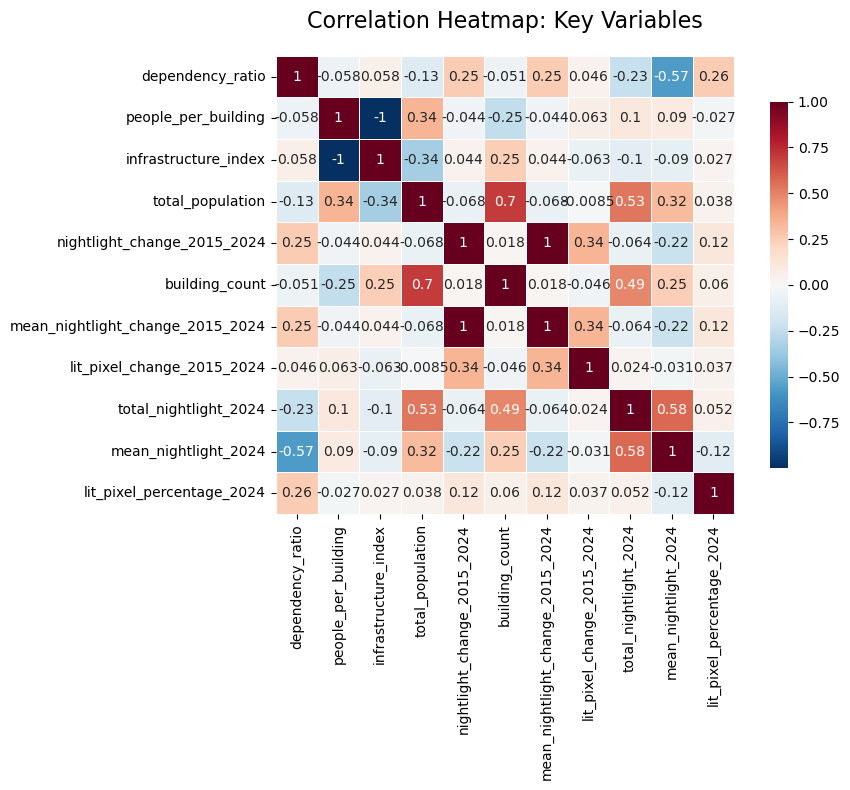

In [26]:
# Select key variables for correlation analysis
key_vars = [
    'dependency_ratio', 'people_per_building', 'infrastructure_index',
    'total_population', 'nightlight_change_2015_2024', "building_count",
    'mean_nightlight_change_2015_2024', 'lit_pixel_change_2015_2024',
    'total_nightlight_2024', 'mean_nightlight_2024', 'lit_pixel_percentage_2024'
]

# Create correlation matrix
corr_matrix = df[key_vars].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap: Key Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


# Based on Manual Inspection, Below is a List of Top and Intresting Correlations
```
'total_population' and 'building_count': 0.7
'dependency_ratio' and 'mean_nightlight_change_2024': -0.57
'total_population' and 'ltotal_night_light_2024': 0.53
```


##  Trends in Night Lights

In [28]:
df_ntl_dist = df.groupby('district_name').agg({
    'nightlight_change_2015_2024': 'mean',
    'lit_pixel_change_2015_2024': 'mean',
    'total_nightlight_2015': 'mean',
    'total_nightlight_2024': 'mean',
    'lit_pixel_percentage_2015': 'mean',
    'lit_pixel_percentage_2024': 'mean'
}).reset_index()

TOP 5 DISTRICTS - HIGHEST NIGHTLIGHT GROWTH (2015-2024):
Nyaruguru: 877.4% growth
Nyagatare: 757.5% growth
Bugesera: 716.3% growth
Kirehe: 639.0% growth
Ngoma: 623.5% growth

BOTTOM 5 DISTRICTS - LOWEST NIGHTLIGHT GROWTH (2015-2024):
Nyarugenge: 192.7% growth
Rubavu: 318.4% growth
Kicukiro: 387.8% growth
Muhanga: 390.8% growth
Nyanza: 399.0% growth


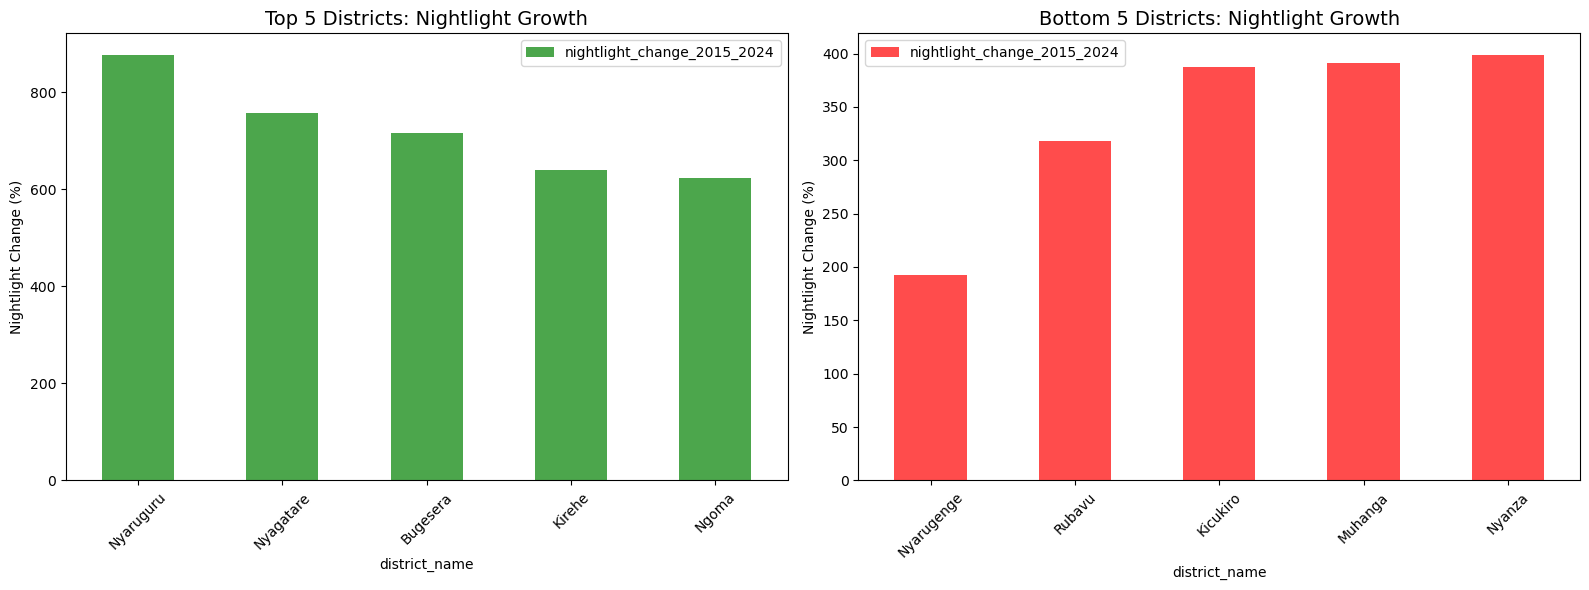

In [30]:
# Top 5 districts with highest nightlight growth
top_5_growth = df_ntl_dist.nlargest(5, 'nightlight_change_2015_2024')
bottom_5_growth = df_ntl_dist.nsmallest(5, 'nightlight_change_2015_2024')

print("TOP 5 DISTRICTS - HIGHEST NIGHTLIGHT GROWTH (2015-2024):")
print("="*60)
for idx, row in top_5_growth.iterrows():
    print(f"{row['district_name']}: {row['nightlight_change_2015_2024']:.1f}% growth")

print("\nBOTTOM 5 DISTRICTS - LOWEST NIGHTLIGHT GROWTH (2015-2024):")
print("="*60)
for idx, row in bottom_5_growth.iterrows():
    print(f"{row['district_name']}: {row['nightlight_change_2015_2024']:.1f}% growth")

# Visualization of extreme districts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5 districts
top_5_growth.plot(x='district_name', y='nightlight_change_2015_2024', 
                 kind='bar', ax=ax1, color='green', alpha=0.7)
ax1.set_title('Top 5 Districts: Nightlight Growth', fontsize=14)
ax1.set_ylabel('Nightlight Change (%)')
ax1.tick_params(axis='x', rotation=45)

# Bottom 5 districts
bottom_5_growth.plot(x='district_name', y='nightlight_change_2015_2024', 
                    kind='bar', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Bottom 5 Districts: Nightlight Growth', fontsize=14)
ax2.set_ylabel('Nightlight Change (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Modelling 

In [36]:
# Prepare variables for modeling
predictor_vars = ['nightlight_change_2015_2024', 'mean_nightlight_change_2015_2024', 'building_count',
    'total_nightlight_2024', 'mean_nightlight_2024', 'lit_pixel_percentage_2024','mean_nightlight_2020',
    'lit_pixel_percentage_2020', 'lit_pixel_change_2015_2024'
]

target_var = 'total_population'

                            OLS Regression Results                            
Dep. Variable:       total_population   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     281.3
Date:                Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                        11:58:08   Log-Likelihood:                -20322.
No. Observations:                2163   AIC:                         4.066e+04
Df Residuals:                    2153   BIC:                         4.072e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

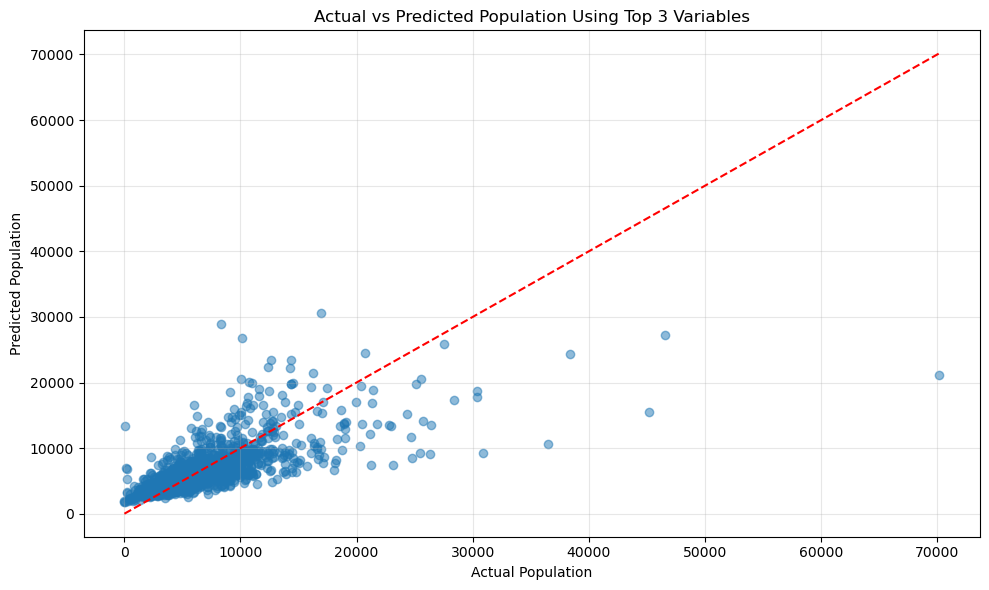

In [37]:
# Filter out rows with NaN values
df_model = df.dropna(subset=predictor_vars + [target_var])

# Add constant term for intercept
X = sm.add_constant(df_model[predictor_vars])
y = df_model[target_var]

# Fit the model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

# Find the top 3 most predictive variables
# We'll use absolute t-statistic values to rank variable importance
var_importance = pd.DataFrame({
    'Variable': predictor_vars,
    'Coefficient': model.params[1:],  # Skip the constant term
    'P-value': model.pvalues[1:],     # Skip the constant term
    'Abs_t_stat': abs(model.tvalues[1:])  # Skip the constant term
}).sort_values('Abs_t_stat', ascending=False)

# Display the top 3 most predictive variables
top_3_vars = var_importance.head(3)
print("\nTop 3 most predictive variables:")
print(top_3_vars)

# Create a simpler model with just the top 3 variables
X_top3 = sm.add_constant(df_model[top_3_vars['Variable'].tolist()])
model_top3 = sm.OLS(y, X_top3).fit()

# Print the simpler model summary
print("\nModel with top 3 variables:")
print(model_top3.summary())

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, model_top3.predict(), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Actual vs Predicted Population Using Top 3 Variables')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
top_3_vars 

,Variable,Coefficient,P-value,Abs_t_stat
building_count,building_count,2.927238,1.425042e-199,33.622678
total_nightlight_2024,total_nightlight_2024,13.706998,1.601139e-27,11.022217
lit_pixel_change_2015_2024,lit_pixel_change_2015_2024,500.780863,8.066012e-03,2.651763
